# TheGraph data access

courtesty of @markusbkoch 
submitted by @mzargham

In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
url = 'https://api.thegraph.com/subgraphs/name/balancer-labs/balancer'
query = '''
query {{
    pools(first: 1000, skip:{}) {{
        id
        liquidity
    }}
}}'''
n = 0
pools = []
while True:
    print(f'request {n+1}')
    v= query.format(n*1000)
    print(v)
    r = requests.post(url, json = {'query':v})
    p = json.loads(r.content)['data']['pools']
    print(f'results {len(p)}')
    pools.extend(p)
    print(f'total {len(pools)}')
    n += 1
    if len(p) < 1000:
        break
subgraph_tvl = pd.DataFrame(pools)

request 1

query {
    pools(first: 1000, skip:0) {
        id
        liquidity
    }
}
results 1000
total 1000
request 2

query {
    pools(first: 1000, skip:1000) {
        id
        liquidity
    }
}
results 1000
total 2000
request 3

query {
    pools(first: 1000, skip:2000) {
        id
        liquidity
    }
}
results 970
total 2970


In [2]:
subgraph_tvl.head()

,id,liquidity
0,0x002d3737e074fb4521036f2c41beba05d221ba69,0
1,0x003a70265a3662342010823bea15dc84c6f7ed54,1636016.131248165544539920705867876
2,0x004e74ff81239c8f2ec0e2815defb970f3754d86,680.928486911431236447041487663722
3,0x0077732357ac0f29e26ea629b79ab3b266ddb796,0.8653140420464888814426818591183125
4,0x0092b2d25d76d84d27b999fe93d5e1c70511cd2b,8.41728837682050716701128507145078


Dealing with pagination here is a pain and the `query` string above does not actually run in the explorer as written. In order to make it easier to move back and forth between the [explorer](https://thegraph.com/explorer/subgraph/balancer-labs/balancer) and the python environment we should build a function to run the same query we use in the explorer, for example:
```
{pools(first:1000){
        id
        liquidity
    }
}
```



In [3]:
def query_theGraph(raw_query, field_name, url, verbose=False):

    query_parts =raw_query.split(')')
    paginator = ", skip:{}"
    #this expectes the raw query to gave a `first:1000` term
    n = 0
    records = []
    while True:
        print(f'request {n+1}')
        skipper = paginator.format(n*1000)
        query = 'query '+query_parts[0]+skipper+')'+query_parts[1]

        if verbose:
            print(query)

        r = requests.post(url, json = {'query':query})

        try:
            d = json.loads(r.content)['data'][field_name]
        except:
            #print(r.content)
            errors = json.loads(r.content)['errors']
            #print(errors)
            for e in errors:
                print(e['message'])

        print(f'results {len(d)}')
        records.extend(d)
        print(f'total {len(records)}')
        n += 1
        if len(d) < 1000:
            break

    return pd.DataFrame(records)

In [4]:
raw_query = '''{pools(first:1000){
        id
        liquidity
    }
}
'''
field_name = 'pools'

subgraph_tvl2 = query_theGraph(raw_query, field_name, url, True)

request 1
query {pools(first:1000, skip:0){
        id
        liquidity
    }
}

results 1000
total 1000
request 2
query {pools(first:1000, skip:1000){
        id
        liquidity
    }
}

results 1000
total 2000
request 3
query {pools(first:1000, skip:2000){
        id
        liquidity
    }
}

results 970
total 2970


In [5]:
subgraph_tvl2.head()

,id,liquidity
0,0x002d3737e074fb4521036f2c41beba05d221ba69,0
1,0x003a70265a3662342010823bea15dc84c6f7ed54,1636016.131248165544539920705867876
2,0x004e74ff81239c8f2ec0e2815defb970f3754d86,680.928486911431236447041487663722
3,0x0077732357ac0f29e26ea629b79ab3b266ddb796,0.8653140420464888814426818591183125
4,0x0092b2d25d76d84d27b999fe93d5e1c70511cd2b,8.41728837682050716701128507145078


In [6]:
subgraph_tvl2.columns = ['id','liquidity2'] 

In [7]:
checker = subgraph_tvl.merge(subgraph_tvl2)

In [8]:
checker['matches'] = checker.liquidity==checker.liquidity2

In [9]:
checker.matches.describe()

count     2970
unique       1
top       True
freq      2970
Name: matches, dtype: object

Now that have checked the data we can proceed with some exploratory analysis.

In [10]:
subgraph_tvl.liquidity= subgraph_tvl.liquidity.apply(float)

In [11]:
subgraph_tvl.sort_values('liquidity', inplace=True)

In [12]:
subgraph_tvl.liquidity

0       0.000000e+00
1722    0.000000e+00
1721    0.000000e+00
1720    0.000000e+00
1718    0.000000e+00
            ...     
1078    6.912330e+07
1623    8.163371e+07
1058    2.673549e+08
2291    3.223070e+08
366     3.499860e+08
Name: liquidity, Length: 2970, dtype: float64

In [13]:
plt_df=subgraph_tvl[subgraph_tvl.liquidity>1].copy().sort_values('liquidity', ascending=False)

In [14]:
subgraph_tvl.describe()

,liquidity
count,2.970000e+03
mean,6.974214e+05
std,1.051697e+07
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,5.651683e+02
max,3.499860e+08


In [15]:
plt_df.tail()

,id,liquidity
340,0x1d261ec7ab834fedb01602c5b7ffc6fc68362bbf,1.577654
986,0x53f160490d7e48ba2c31be4790f3d87a2f4dc662,1.371422
1849,0x9e4a4b53e19410ae519be74f92659e5b0ef9489b,1.330313
2354,0xcb8ec8236aff8e112517f4e9a9ffb413a237e6b7,1.153105
1296,0x6d42692518c8b09c883e7c1e69c97518107f2185,1.030083


/Users/zargham/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0.0, 0, '0x1eff8af5d577060ba4ac8a29a13525bb0ee2a3d5'),
  Text(200.0, 0, '0x046d26561f4ce508cb44e05ab0584436b2b2f400'),
  Text(400.0, 0, '0x76958fa640ca66e8f4337a0d874b2d8a6c408f95'),
  Text(600.0, 0, '0xed3d99d838ab16e8a0543bb91f254139a0fcb8dd'),
  Text(800.0, 0, '0x60332a3263722c380ba8c0a42ff69d8e45498692'),
  Text(1000.0, 0, '0xd58eef5b3741919d62d68c14958d0418166edb2b'),
  Text(1200.0, 0, '')])

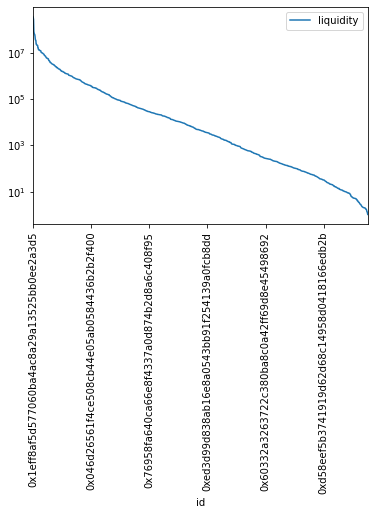

In [16]:
plt_df.plot(x='id', y='liquidity', logy=True)
plt.xticks(rotation=90)

In [17]:
plt_df['cumulative liquidity'] = plt_df.liquidity.cumsum()

/Users/zargham/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0.0, 0, '0x1eff8af5d577060ba4ac8a29a13525bb0ee2a3d5'),
  Text(200.0, 0, '0x046d26561f4ce508cb44e05ab0584436b2b2f400'),
  Text(400.0, 0, '0x76958fa640ca66e8f4337a0d874b2d8a6c408f95'),
  Text(600.0, 0, '0xed3d99d838ab16e8a0543bb91f254139a0fcb8dd'),
  Text(800.0, 0, '0x60332a3263722c380ba8c0a42ff69d8e45498692'),
  Text(1000.0, 0, '0xd58eef5b3741919d62d68c14958d0418166edb2b'),
  Text(1200.0, 0, '')])

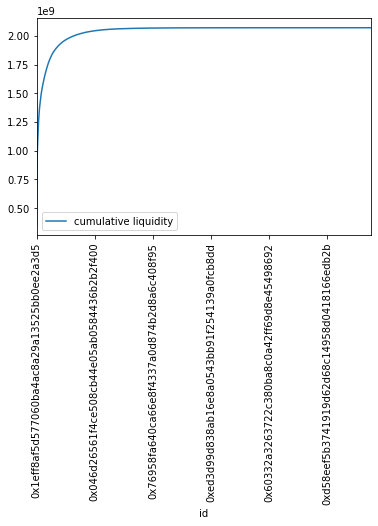

In [18]:
plt_df.plot(x='id', y='cumulative liquidity', logy=False)
plt.xticks(rotation=90)